In [1]:
import pandas as pd

# Load the data
data_path = 'Australian_credit_data.csv'
data = pd.read_csv(data_path)

# Display the first few rows of the dataset
data.head()


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15
0,1,22.08,11.46,2,4,4,1.585,0,0,0,1,2,100,1213,0
1,0,22.67,7.00,2,8,4,0.165,0,0,0,0,2,160,1,0
2,0,29.58,1.75,1,4,4,1.250,0,0,0,1,2,280,1,0
3,0,21.67,11.50,1,5,3,0.000,1,1,11,1,2,0,1,1
4,1,20.17,8.17,2,6,4,1.960,1,1,14,0,2,60,159,1


In [2]:
from sklearn.preprocessing import MinMaxScaler

# Separate features and labels using column names
X = data.drop(columns=['A15']).values  # Drop the target label column
y = data['A15'].values  # Extract the target label column

# Normalize the features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Display the normalized features
pd.DataFrame(X_scaled, columns=data.columns[:-1]).head()


,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14
0,1.0,0.125263,0.409286,0.5,0.230769,0.375,0.055614,0.0,0.0,0.000000,1.0,0.5,0.05,0.01212
1,0.0,0.134135,0.250000,0.5,0.538462,0.375,0.005789,0.0,0.0,0.000000,0.0,0.5,0.08,0.00000
2,0.0,0.238045,0.062500,0.0,0.230769,0.375,0.043860,0.0,0.0,0.000000,1.0,0.5,0.14,0.00000
3,0.0,0.119098,0.410714,0.0,0.307692,0.250,0.000000,1.0,1.0,0.164179,1.0,0.5,0.00,0.00000
4,1.0,0.096541,0.291786,0.5,0.384615,0.375,0.068772,1.0,1.0,0.208955,0.0,0.5,0.03,0.00158


In [6]:
from minisom import MiniSom

# Initialize the SOM
som = MiniSom(x=10, y=10, input_len=X_scaled.shape[1], sigma=1.0, learning_rate=0.5)

# Train the SOM
som.random_weights_init(X_scaled)
som.train_random(data=X_scaled, num_iteration=100)

# Display SOM weights indirectly by checking if the training is done
print("SOM training completed.")


SOM training completed.


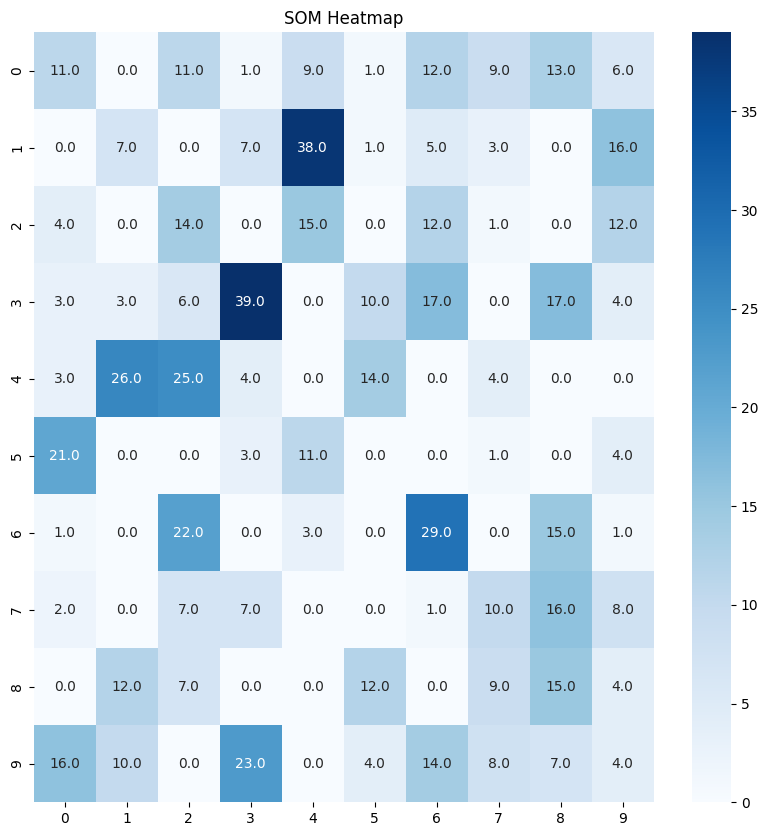

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Get the mapping of the data points to the SOM
mapped = np.array([som.winner(x) for x in X_scaled])

# Create a heatmap of the SOM
heatmap_data = np.zeros((10, 10))
for i in range(10):
    for j in range(10):
        heatmap_data[i, j] = np.sum((mapped[:, 0] == i) & (mapped[:, 1] == j))

plt.figure(figsize=(10, 10))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Blues")
plt.title('SOM Heatmap')
plt.show()


Epoch 1/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6012 - loss: 0.6864 - val_accuracy: 0.7029 - val_loss: 0.6578
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8196 - loss: 0.6393 - val_accuracy: 0.7754 - val_loss: 0.6040
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8625 - loss: 0.5551 - val_accuracy: 0.7971 - val_loss: 0.5192
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8668 - loss: 0.4299 - val_accuracy: 0.7899 - val_loss: 0.4486
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8899 - loss: 0.3363 - val_accuracy: 0.8261 - val_loss: 0.4352
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8812 - loss: 0.3038 - val_accuracy: 0.7899 - val_loss: 0.4314
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8844 - loss: 0.2882 - val_accuracy: 0.7899 - val_loss: 0.4350
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8647 - loss: 0.2980 - val_accuracy: 0.7826 - 

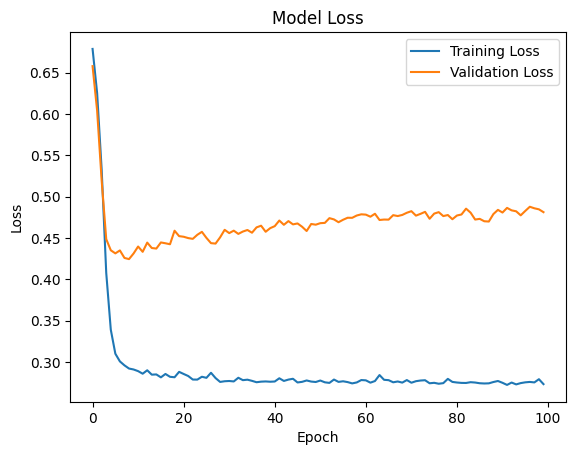

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Prepare input for the ANN
X_som = np.array([som.winner(x) for x in X_scaled])
X_som = X_som[:, 0] * 10 + X_som[:, 1]  # Flatten the 2D mapping to 1D

# One-hot encode the SOM clusters
X_som_encoded = tf.keras.utils.to_categorical(X_som, num_classes=100)

# Build the ANN
model = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_som_encoded, y, epochs=100, batch_size=32, validation_split=0.2)

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [12]:
# Evaluate the model
loss, accuracy = model.evaluate(X_som_encoded, y)
print(f'Final Loss: {loss}')
print(f'Final Accuracy: {accuracy}')


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - accuracy: 0.8869 - loss: 0.2572
Final Loss: 0.3274824321269989
Final Accuracy: 0.8608695864677429


In [22]:
import numpy as np

def preprocess_input(row, scaler):
    # Normalize the input row
    row_scaled = scaler.transform([row])
    return row_scaled

def map_to_som(som, row_scaled):
    # Map the normalized input row to the SOM
    winner_node = som.winner(row_scaled[0])
    som_input = winner_node[0] * 10 + winner_node[1]  # Flatten the 2D mapping to 1D
    return som_input

def encode_som_input(som_input):
    # One-hot encode the SOM input
    som_input_encoded = tf.keras.utils.to_categorical([som_input], num_classes=100)
    return som_input_encoded

def predict_target(model, som_input_encoded):
    # Predict the target using the ANN model
    prediction = model.predict(som_input_encoded)
    return prediction[0][0]

def predict_from_user_input():
    # Ask the user for input
    user_input = input("Please enter a row of data (comma-separated or tab-separated): ")
    
    # Handle both comma-separated and tab-separated inputs
    if '\t' in user_input:
        row = list(map(float, user_input.split('\t')))
    else:
        row = list(map(float, user_input.split(',')))
    
    # Preprocess the row
    row_scaled = preprocess_input(row, scaler)
    
    # Map to SOM
    som_input = map_to_som(som, row_scaled)
    
    # Encode SOM input
    som_input_encoded = encode_som_input(som_input)
    
    # Predict the target
    prediction = predict_target(model, som_input_encoded)
    
    # Print the prediction
    print(f'Predicted Target probability: {prediction}')
    if(prediction > 0.5):
        print(f'Predicted Target: 1')
    else:
        print(f'Predicted Target: 0')

# Call the function to predict from user input
predict_from_user_input()


Please enter a row of data (comma-separated or tab-separated):  1	21.17	0	2	8	4	0.5	0	0	0	1	1	0	1


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Predicted Target probability: 0.34544721245765686
Predicted Target: 0
